In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import pandas as pd
from numpyro.infer import Predictive, MCMC, NUTS

In [2]:
# colors
RED = "#f5b9b8"

In [3]:
from plotting import ribbon_plot, spaghetti_plot

In [4]:
numpyro.set_host_device_count(4)

In [5]:
# Population in England
POPULATION = 56e6
POPULATION_PER_100k = POPULATION / 1e5

In [6]:
rng = jax.random.PRNGKey(233)

In [7]:
data = pd.read_csv("./data/daily_by_region.csv", index_col="date", parse_dates=["date"]).sum(axis=1)

<AxesSubplot:xlabel='date'>

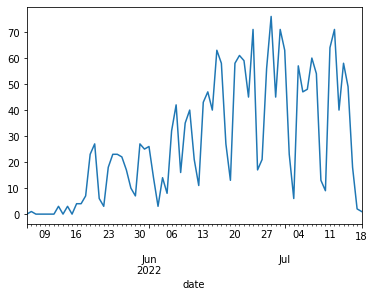

In [8]:
data.plot()

In [9]:
# I do not trust the early reported numbers
# I also drop a few recent values becuase they claim
# there's a lot of lag in the data reporting
num_discard = 12
data = data.iloc[num_discard:-5]

In [10]:
data

date
2022-05-17     4.0
2022-05-18     7.0
2022-05-19    23.0
2022-05-20    27.0
2022-05-21     6.0
2022-05-22     3.0
2022-05-23    18.0
2022-05-24    23.0
2022-05-25    23.0
2022-05-26    22.0
2022-05-27    17.0
2022-05-28    10.0
2022-05-29     7.0
2022-05-30    27.0
2022-05-31    25.0
2022-06-01    26.0
2022-06-02    14.0
2022-06-03     3.0
2022-06-04    14.0
2022-06-05     8.0
2022-06-06    32.0
2022-06-07    42.0
2022-06-08    16.0
2022-06-09    35.0
2022-06-10    40.0
2022-06-11    21.0
2022-06-12    11.0
2022-06-13    43.0
2022-06-14    47.0
2022-06-15    40.0
2022-06-16    63.0
2022-06-17    58.0
2022-06-18    27.0
2022-06-19    13.0
2022-06-20    58.0
2022-06-21    61.0
2022-06-22    59.0
2022-06-23    45.0
2022-06-24    71.0
2022-06-25    17.0
2022-06-26    21.0
2022-06-27    56.0
2022-06-28    76.0
2022-06-29    45.0
2022-06-30    71.0
2022-07-01    63.0
2022-07-02    23.0
2022-07-03     6.0
2022-07-04    57.0
2022-07-05    47.0
2022-07-06    48.0
2022-07-07    60.0
2022-07

In [11]:
dates = data.index
date0 = dates[0]
times = (dates - date0).days
cases = data.values

In [12]:
dates

DatetimeIndex(['2022-05-17', '2022-05-18', '2022-05-19', '2022-05-20',
               '2022-05-21', '2022-05-22', '2022-05-23', '2022-05-24',
               '2022-05-25', '2022-05-26', '2022-05-27', '2022-05-28',
               '2022-05-29', '2022-05-30', '2022-05-31', '2022-06-01',
               '2022-06-02', '2022-06-03', '2022-06-04', '2022-06-05',
               '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09',
               '2022-06-10', '2022-06-11', '2022-06-12', '2022-06-13',
               '2022-06-14', '2022-06-15', '2022-06-16', '2022-06-17',
               '2022-06-18', '2022-06-19', '2022-06-20', '2022-06-21',
               '2022-06-22', '2022-06-23', '2022-06-24', '2022-06-25',
               '2022-06-26', '2022-06-27', '2022-06-28', '2022-06-29',
               '2022-06-30', '2022-07-01', '2022-07-02', '2022-07-03',
               '2022-07-04', '2022-07-05', '2022-07-06', '2022-07-07',
               '2022-07-08', '2022-07-09', '2022-07-10', '2022-07-11',
      

In [13]:
dates.weekday

Int64Index([1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1,
            2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2,
            3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2],
           dtype='int64', name='date')

#### Model

In [14]:
t = jnp.array(times / 100, dtype=jnp.float32) # Renormalize time units
y = jnp.array(cases, dtype=jnp.int32)
is_weekend = jnp.array((dates.weekday == 5) | (dates.weekday == 6))

In [15]:
@jax.jit
def richards(t, amplitude, rate, peak, skew):
    denominator = 1 + skew * jnp.exp(-rate * (t - peak))
    return amplitude / denominator ** (1 / skew)

In [16]:
# Derivative of the Richards' growth curve with respect to time
drichards = jax.jit(jax.vmap(jax.grad(richards, argnums=0), in_axes=(0, None, None, None, None)))

In [17]:
def epidemic_model(t, is_weekend, y=None):
    # Number of infected per 100k
    amplitude = numpyro.sample("amplitude", dist.Beta(2, 10))
    
    # Growth rate
    rate = numpyro.sample("rate", dist.Exponential(rate=.1))
    
    # (Normalized) time position of the "peak"
    peak = numpyro.sample("peak", dist.LogNormal())
    
    # Skewness
    # NOTE:
    # -----
    #     skew > 1 means down ramp is faster than ramp up
    #     skew < 1 means down ramp is slower than ramp up
    #     skew = 1 means the curve is symmetric
    #
    # I'm placing a very opinionated prior, ruling out
    # the possibility of skew >= 1. Why?
    # Because it's my model.
    skew = numpyro.sample("skew", dist.Beta(5, 5))
    
    # Weekend effect
    weekend_factor = numpyro.sample("weekend_factor", dist.LogNormal())
    day_effect = jnp.where(is_weekend, weekend_factor, 1.0)
    
    # Concentration
    concentration = numpyro.sample("concentration", dist.LogNormal())
    
    # Mean
    mu = drichards(t, amplitude, rate, peak, skew)
    mu = mu * POPULATION_PER_100k
    numpyro.deterministic("mu", mu)
    
    # Mean with seasonality
    seasonal_mu = mu * day_effect
    numpyro.deterministic("seasonal_mu", mu)

    # --- Likelihood
    numpyro.sample("y", dist.NegativeBinomial2(seasonal_mu, concentration), obs=y)

#### Prior simulations

In [18]:
rng, prior_rng = jax.random.split(rng)

In [19]:
prior = Predictive(epidemic_model, num_samples=400)

In [20]:
prior_samples = prior(prior_rng, t=t, is_weekend=is_weekend)

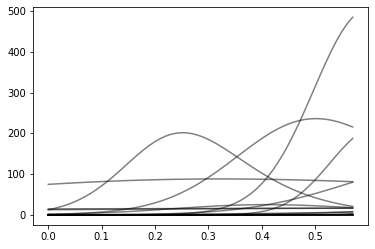

In [21]:
spaghetti_plot(t, prior_samples['mu'], plot_kwargs=dict(color='k', alpha=0.5));

#### MCMC

In [22]:
rng, mcmc_rng = jax.random.split(rng)

In [23]:
mcmc = MCMC(NUTS(model=epidemic_model), num_warmup=4000, num_samples=2000, num_chains=4, chain_method='parallel')

In [24]:
mcmc.run(mcmc_rng, t=t, is_weekend=is_weekend, y=y)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [25]:
mcmc.print_summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
       amplitude      0.09      0.03      0.08      0.06      0.13   1068.21      1.00
   concentration     10.05      3.10      9.64      5.34     14.74   4267.18      1.00
            peak      0.51      0.11      0.48      0.38      0.64   1171.67      1.00
            rate      4.32      0.93      4.33      2.83      5.89   1785.17      1.00
            skew      0.51      0.15      0.51      0.27      0.77   4324.60      1.00
  weekend_factor      0.33      0.04      0.32      0.26      0.39   6064.42      1.00

Number of divergences: 0


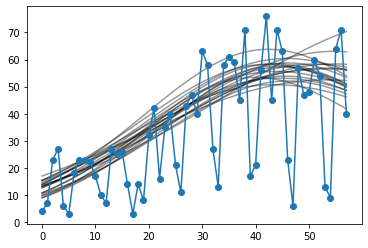

In [26]:
spaghetti_plot(times, mcmc.get_samples()["mu"], plot_kwargs=dict(color='k', alpha=0.4))
plt.plot(times, cases, marker='o')

#### Predictive checks

In [27]:
pred_rng, rng = jax.random.split(rng)

In [28]:
predictive = Predictive(epidemic_model, posterior_samples=mcmc.get_samples())

In [29]:
predictive_samples = predictive(pred_rng, t=t, is_weekend=is_weekend)

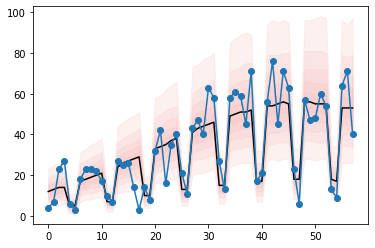

In [30]:
ribbon_plot(times, predictive_samples["y"], percentile_max=95, percentile_min=5, ribbon_color=RED, n_ribbons=5)
plt.plot(times, cases, marker='o')

### Forecast

In [31]:
num_forecast_days = 21
forecast_dates = pd.date_range(dates[0], periods=len(dates) + num_forecast_days, freq='D')
forecast_times = (forecast_dates - date0).days
forecast_rtimes = jnp.array(forecast_times / 100) # renormalize
forecast_is_weekend = jnp.array((forecast_dates.weekday == 5) | (forecast_dates.weekday == 6))

In [32]:
forecast_samples = predictive(pred_rng, t=forecast_rtimes, is_weekend=forecast_is_weekend)

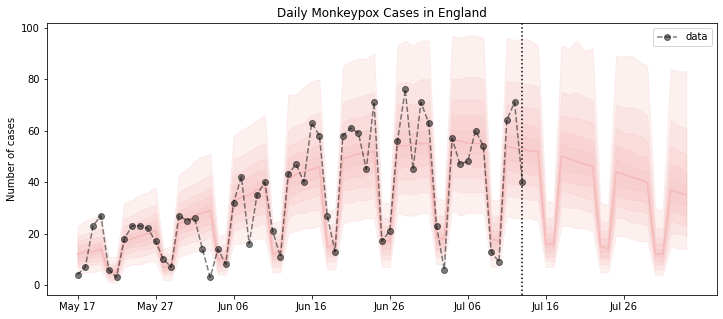

In [33]:
fig = plt.figure(figsize=(12, 5))
ribbon_plot(forecast_times, forecast_samples["y"], percentile_max=95, percentile_min=5, ribbon_color=RED, n_ribbons=5, line_color=RED)
plt.plot(times, cases, marker='o', mec='k', c='k', alpha=0.5, linestyle='--', label='data')
plt.axvline(times[-1], linestyle=":", color='k')
plt.xticks(forecast_times[::10], labels=forecast_dates.strftime("%b %d")[::10])
plt.ylabel("Number of cases")
plt.title("Daily Monkeypox Cases in England")
plt.legend()
plt.show()

In [34]:
fig.savefig("./model.png", dpi=300)

##### Watermark

In [35]:
%load_ext watermark

In [36]:
%watermark -uvmrb -iv --date

Last updated: 2022-07-31

Python implementation: CPython
Python version       : 3.10.1
IPython version      : 8.4.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.11.0-1022-aws
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

Git repo: git@github.com:omarfsosa/monkeypox.git

Git branch: master

pandas    : 1.4.3
jax       : 0.3.15
numpyro   : 0.10.0
matplotlib: 3.5.2

